In [2]:
import torch
from torchvision import datasets, transforms

from projections import LayerModifier
from notebook_train import run_train_test_loop, test
from cifar_model import mCNN_k


In [3]:
# for now, no augmentations

torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset1 = datasets.CIFAR10('data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.CIFAR10('data', train=False,
                   transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, num_workers = 4, pin_memory = True, batch_size=32, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset2,  num_workers = 4, pin_memory = True, batch_size=32)

model = mCNN_k().to(device)

    
retrain = False
if retrain:
    run_train_test_loop(model, train_loader, test_loader, "cifar_10", epochs=50, device=device)    
else:
    model = mCNN_k().to(device).eval()
    state_dict = torch.load("models/cifar_10.pt",) # map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)


Files already downloaded and verified


In [4]:
test(model, device, test_loader, torch.nn.CrossEntropyLoss())


Test set: Average loss: 0.0422, Accuracy: 8071/10000 (81%)



(0.04220272497474216, 80.71)

In [14]:
# pip install torchinfo
from torchinfo import summary


summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Conv2d: 1-1                            [1, 64, 32, 32]           1,792
├─ReLU: 1-2                              [1, 64, 32, 32]           --
├─Conv2d: 1-3                            [1, 128, 32, 32]          73,728
├─ReLU: 1-4                              [1, 128, 32, 32]          --
├─MaxPool2d: 1-5                         [1, 128, 16, 16]          --
├─Conv2d: 1-6                            [1, 256, 16, 16]          294,912
├─ReLU: 1-7                              [1, 256, 16, 16]          --
├─MaxPool2d: 1-8                         [1, 256, 8, 8]            --
├─Conv2d: 1-9                            [1, 512, 8, 8]            1,179,648
├─ReLU: 1-10                             [1, 512, 8, 8]            --
├─MaxPool2d: 1-11                        [1, 512, 4, 4]            --
├─MaxPool2d: 1-12                        [1, 512, 1, 1]           

## CIFAR-10 experiments *with* random initialization for layers > $i$

In [9]:
net1 = mCNN_k().to(device)
net1[0] = LayerModifier(torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=True), dims=64).to(device)
for p in net1[0].parameters():
    p.requires_grad = False

new_state_dict = net1.state_dict()
state_dict = torch.load("models/cifar_10.pt",) # map_location=torch.device('cpu'))]
# hacky as hell
state_dict = {k.replace("0", "0.original_op"): v for k, v in state_dict.items()}
new_state_dict.update(state_dict)
net1.load_state_dict(new_state_dict)
test(net1, device, test_loader, torch.nn.CrossEntropyLoss())
summary(net1)


Test set: Average loss: 0.1019, Accuracy: 1796/10000 (18%)



Layer (type:depth-idx)                   Param #
Sequential                               --
├─LayerModifier: 1-1                     --
│    └─Conv2d: 2-1                       (1,792)
├─ReLU: 1-2                              --
├─Conv2d: 1-3                            73,728
├─ReLU: 1-4                              --
├─MaxPool2d: 1-5                         --
├─Conv2d: 1-6                            294,912
├─ReLU: 1-7                              --
├─MaxPool2d: 1-8                         --
├─Conv2d: 1-9                            1,179,648
├─ReLU: 1-10                             --
├─MaxPool2d: 1-11                        --
├─MaxPool2d: 1-12                        --
├─Flatten: 1-13                          --
├─Linear: 1-14                           5,120
Total params: 1,555,200
Trainable params: 1,553,408
Non-trainable params: 1,792

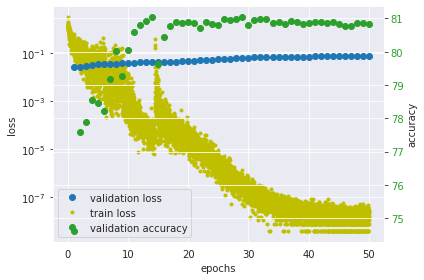

best acc: 81.04


In [10]:
run_train_test_loop(
    net1, 
    train_loader, 
    test_loader, 
    "cifar_10_freeze_layer1_reinit_conv1x1", 
    epochs=50, 
    device=device
)    

In [18]:
net2 = mCNN_k().to(device)
net2[0] = LayerModifier(torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=True), dims=64).to(device)
net2[2] = LayerModifier(torch.nn.Conv2d(64, 64 * 2, kernel_size=3, stride=1, padding=1, bias=False), dims=128).to(device)

for p in net2[0].parameters():
    p.requires_grad = False
for p in net2[2].parameters():
    p.requires_grad = False

new_state_dict = net2.state_dict()
state_dict = torch.load("models/cifar_10_freeze_layer1_reinit_conv1x1.pt",) # map_location=torch.device('cpu'))]
# hacky as hell
state_dict = {k.replace("2", "2.original_op"): v for k, v in state_dict.items()}
new_state_dict.update(state_dict)
net2.load_state_dict(new_state_dict)
test(net2, device, test_loader, torch.nn.CrossEntropyLoss())
summary(net2)


Test set: Average loss: 0.2013, Accuracy: 1181/10000 (12%)



Layer (type:depth-idx)                   Param #
Sequential                               --
├─LayerModifier: 1-1                     --
│    └─Conv2d: 2-1                       (1,792)
├─ReLU: 1-2                              --
├─LayerModifier: 1-3                     --
│    └─Conv2d: 2-2                       (73,728)
├─ReLU: 1-4                              --
├─MaxPool2d: 1-5                         --
├─Conv2d: 1-6                            294,912
├─ReLU: 1-7                              --
├─MaxPool2d: 1-8                         --
├─Conv2d: 1-9                            1,179,648
├─ReLU: 1-10                             --
├─MaxPool2d: 1-11                        --
├─MaxPool2d: 1-12                        --
├─Flatten: 1-13                          --
├─Linear: 1-14                           5,120
Total params: 1,555,200
Trainable params: 1,479,680
Non-trainable params: 75,520

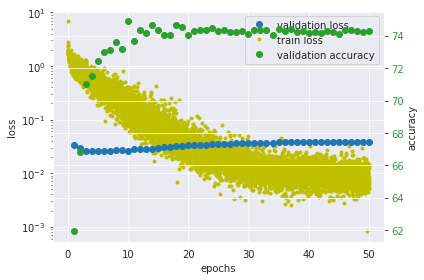

best acc: 74.88


In [20]:
run_train_test_loop(
    net2, 
    train_loader, 
    test_loader, 
    "cifar_10_freeze_layer2_reinit_conv1x1", 
    epochs=50, 
    device=device
)    

In [22]:
state_dict.keys()

dict_keys(['0.original_op.weight', '0.original_op.bias', '2.original_op.weight', '5.weight', '8.weight', '13.weight'])

In [24]:
net3 = mCNN_k().to(device)
net3[0] = LayerModifier(torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=True), dims=64).to(device)
net3[2] = LayerModifier(torch.nn.Conv2d(64, 64 * 2, kernel_size=3, stride=1, padding=1, bias=False), dims=128).to(device)
net3[5] = LayerModifier(torch.nn.Conv2d(64 * 2, 64 * 4, kernel_size=3, stride=1, padding=1, bias=False), dims=256).to(device)

for p in net3[0].parameters():
    p.requires_grad = False
for p in net3[2].parameters():
    p.requires_grad = False
for p in net3[5].parameters():
    p.requires_grad = False


new_state_dict = net3.state_dict()
state_dict = torch.load("models/cifar_10_freeze_layer2_reinit_conv1x1.pt",) # map_location=torch.device('cpu'))]
# hacky as hell
state_dict = {k.replace("5", "5.original_op"): v for k, v in state_dict.items()}
new_state_dict.update(state_dict)
net3.load_state_dict(new_state_dict)
test(net3, device, test_loader, torch.nn.CrossEntropyLoss())
summary(net3)


Test set: Average loss: 0.1545, Accuracy: 1126/10000 (11%)



Layer (type:depth-idx)                   Param #
Sequential                               --
├─LayerModifier: 1-1                     --
│    └─Conv2d: 2-1                       (1,792)
├─ReLU: 1-2                              --
├─LayerModifier: 1-3                     --
│    └─Conv2d: 2-2                       (73,728)
├─ReLU: 1-4                              --
├─MaxPool2d: 1-5                         --
├─LayerModifier: 1-6                     --
│    └─Conv2d: 2-3                       (294,912)
├─ReLU: 1-7                              --
├─MaxPool2d: 1-8                         --
├─Conv2d: 1-9                            1,179,648
├─ReLU: 1-10                             --
├─MaxPool2d: 1-11                        --
├─MaxPool2d: 1-12                        --
├─Flatten: 1-13                          --
├─Linear: 1-14                           5,120
Total params: 1,555,200
Trainable params: 1,184,768
Non-trainable params: 370,432

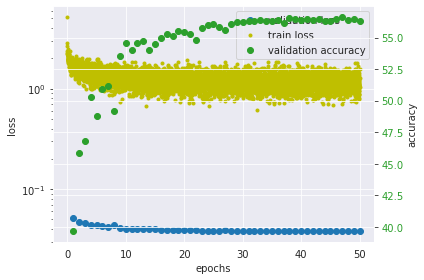

best acc: 56.62


In [26]:
run_train_test_loop(
    net3, 
    train_loader, 
    test_loader, 
    "cifar_10_freeze_layer3_reinit_conv1x1", 
    epochs=50, 
    device=device
)    

In [29]:
net4 = mCNN_k().to(device)
net4[0] = LayerModifier(torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=True), dims=64).to(device)
net4[2] = LayerModifier(torch.nn.Conv2d(64, 64 * 2, kernel_size=3, stride=1, padding=1, bias=False), dims=128).to(device)
net4[5] = LayerModifier(torch.nn.Conv2d(64 * 2, 64 * 4, kernel_size=3, stride=1, padding=1, bias=False), dims=256).to(device)
net4[8] = LayerModifier(torch.nn.Conv2d(64 * 4, 64 * 8, kernel_size=3, stride=1, padding=1, bias=False), dims=512).to(device)

for p in net4[0].parameters():
    p.requires_grad = False
for p in net4[2].parameters():
    p.requires_grad = False
for p in net4[5].parameters():
    p.requires_grad = False
for p in net4[8].parameters():
    p.requires_grad = False


new_state_dict = net4.state_dict()
state_dict = torch.load("models/cifar_10_freeze_layer3_reinit_conv1x1.pt",) # map_location=torch.device('cpu'))]
# hacky as hell
state_dict = {k.replace("8", "8.original_op"): v for k, v in state_dict.items()}
new_state_dict.update(state_dict)
net4.load_state_dict(new_state_dict)
test(net4, device, test_loader, torch.nn.CrossEntropyLoss())
summary(net4)


Test set: Average loss: 4.9850, Accuracy: 1000/10000 (10%)



Layer (type:depth-idx)                   Param #
Sequential                               --
├─LayerModifier: 1-1                     --
│    └─Conv2d: 2-1                       (1,792)
├─ReLU: 1-2                              --
├─LayerModifier: 1-3                     --
│    └─Conv2d: 2-2                       (73,728)
├─ReLU: 1-4                              --
├─MaxPool2d: 1-5                         --
├─LayerModifier: 1-6                     --
│    └─Conv2d: 2-3                       (294,912)
├─ReLU: 1-7                              --
├─MaxPool2d: 1-8                         --
├─LayerModifier: 1-9                     --
│    └─Conv2d: 2-4                       (1,179,648)
├─ReLU: 1-10                             --
├─MaxPool2d: 1-11                        --
├─MaxPool2d: 1-12                        --
├─Flatten: 1-13                          --
├─Linear: 1-14                           5,120
Total params: 1,555,200
Trainable params: 5,120
Non-trainable params: 1,550,080

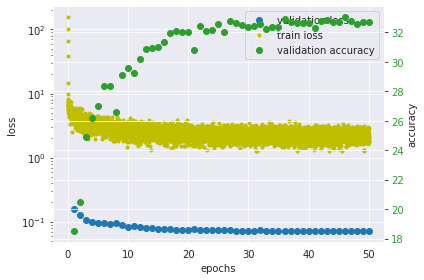

best acc: 33.03


In [30]:
run_train_test_loop(
    net4, 
    train_loader, 
    test_loader, 
    "cifar_10_freeze_layer4_reinit_conv1x1", 
    epochs=50, 
    device=device
)    